In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from scipy import stats
from scipy.optimize import curve_fit
import json

### Ensemble-averaged mean squared displacement (EMSD)

In [3]:
def get_disp_dict_from_file(filename, window, step_size, max_step_size, restriction):

    with open('disp_dict_data/'+filename+'_s{}/'.format(max_step_size)+'disp_dict_'+filename
              +'_w{}_step{}_r{}'.format(window, step_size, restriction), 'r') as f:
        disp_dict = f.read()
    
    return json.loads(disp_dict)

def get_disp_time_dict_from_file(filename, window, step_size, max_step_size, restriction):
    
    with open('disp_dict_data/'+filename+'_s{}/'.format(max_step_size)+'disp_time_dict_'+filename
              +'_w{}_step{}_r{}'.format(window, step_size, restriction), 'r') as f:
        disp_time_dict = f.read()
    
    return json.loads(disp_time_dict)

def get_step_length_dict_from_file(filename, window, step_size, max_step_size, restriction):
    
    with open('disp_dict_data/'+filename+'_s{}/'.format(max_step_size)+'step_length_dict_'+filename
              +'_w{}_step{}_r{}'.format(window, step_size, restriction), 'r') as f:
        step_length_dict = f.read()
    
    return json.loads(step_length_dict)

In [4]:
def get_emsd(disp_dict, disp_time_dict):
    
    max_length = max(len(disps) for disps in disp_dict.values())
    
    all_times = np.array([])
    for t_values in disp_time_dict.values():
        all_times = np.append(all_times, t_values)
    unique_t_values = np.unique(all_times)  
    # at each of these times, we will compute squared displacement averaged over tracks (ensemble average)
    
    emsd_means = np.empty(max_length)
    #emsd_stds = np.empty(max_length)
    emsd_error = np.empty(max_length)
    times = np.empty(max_length)
    
    for i, t in enumerate(unique_t_values):
        # get dictionary of indices where that particular time occurs
        index_dict = {key:times.index(t) for (key,times) in disp_time_dict.items() if t in times}
        keys_to_keep = list(index_dict)  # only keeping tracks that include a point at this particular time
        disps_at_t = np.array([])
        for key in keys_to_keep:
            index = index_dict[key]
            disp_at_t = disp_dict[key][index]
            disps_at_t = np.append(disps_at_t, disp_at_t)
        squared_disps_at_t = np.power(disps_at_t, 2)
    
        temp_mean = np.mean(squared_disps_at_t)
        temp_std = np.std(squared_disps_at_t)
        emsd_means[i] = temp_mean
        #emsd_stds[i] = temp_std
        emsd_error[i] = temp_std/np.sqrt(len(index_dict)-1)
        times[i] = t
        
    return emsd_means[1:], emsd_error[1:], times[1:]

In [5]:
def plot_emsd(filename, window, step_sizes, restriction, step_to_plot=1, errorbar=False):
    
    disp_dict = get_disp_dict_from_file(filename, window, step_to_plot, max(step_sizes), restriction)
    disp_time_dict = get_disp_time_dict_from_file(filename, window, step_to_plot, max(step_sizes), restriction)
    
    emsd_means, emsd_error, times = get_emsd(disp_dict, disp_time_dict)
    
    plt.title(filename)
    plt.xlabel('Time (s)')
    plt.ylabel(r'EMSD ($\mu m^2$)')
    if errorbar:
        plt.errorbar(times, emsd_means, yerr=emsd_error)
    else:
        plt.scatter(times, emsd_means, s=2)

In [6]:
def power_law(t, k, a):
    return k * np.power(t,a)

In [7]:
def subplot_emsd_time(filename, window, step_sizes, restriction, pos, errorbar=False, step_to_plot=1):
    """
    """
    i, j = pos
    
    disp_dict = get_disp_dict_from_file(filename, window, step_to_plot, max(step_sizes), restriction)
    disp_time_dict = get_disp_time_dict_from_file(filename, window, step_to_plot, max(step_sizes), restriction)
    emsd_means, emsd_error, times = get_emsd(disp_dict, disp_time_dict)
    
    # power law fit
    popt, pcov = curve_fit(power_law, times, emsd_means)
    perr = np.sqrt(np.diag(pcov))
    
    ax[i,j].set_xlabel('Time (s)')
    ax[i,j].set_ylabel(r'EMSD ($\mu m^2$)')
    ax[i,j].set_title(filename)
    if errorbar:
        ax[i,j].errorbar(times, emsd_means, yerr=emsd_error)
    else:
        ax[i,j].scatter(times, emsd_means, s=2)
        ax[i,j].plot(times, power_law(times, *popt), color='y', label=r'Fit: $\langle{r}^2\rangle$ = $kt^a$')
        ax[i,j].annotate(r'$k={:.4f}\pm{:.4f}$ $\mu m^2$'.format(popt[0],perr[0])+'\n'
                         +r'$a={:.3f}\pm{:.3f}$'.format(popt[1],perr[1])+'\n'
                         +r'$H=a/2={:.3f}\pm{:.3f}$'.format(popt[1]/2,perr[1]/2),(0.05,0.65), xycoords='axes fraction')
        ax[i,j].legend()

In [8]:
filenames = np.array(['Control_frame001-200',
                      'Control_frame200-400',
                      'Control_frame400-600',
                      'Control_frame600-800',
                      'Control_frame800-1000',
                      'Control_frame1000-1200',
                      'LanB1_frame001-200',
                      'LanB1_frame200-400',
                      'LanB1_frame400-600',
                      'LanB1_frame600-800',
                      'LanB1_frame800-1000',
                      'LanB1_frame1000-1200',
                      'defLanB1_300817_frame200-400',
                      'defLanB1_300817_frame400-600'])

In [9]:
window = 20
step_sizes = [1,2,3,4,5,6,7,8]
restriction = 10000

step_to_plot = 1 # no downsampling

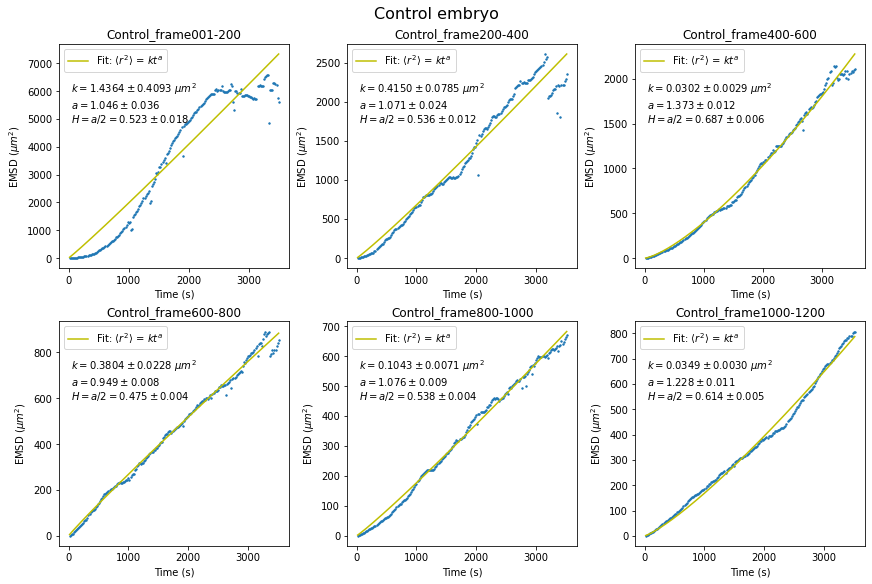

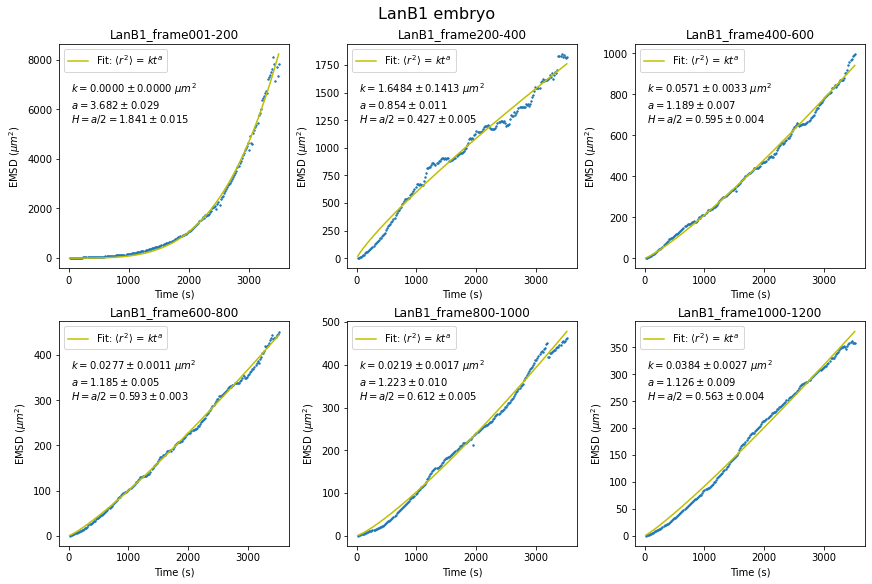

In [10]:
# without errorbars
#Control
fig, ax = plt.subplots(2, 3, figsize=(12, 8), constrained_layout=True)
fig.suptitle("Control embryo", fontsize=16)
for j, f in enumerate(filenames[0:3]):
    subplot_emsd_time(f, window, step_sizes, restriction, pos=[0,j])
for j, f in enumerate(filenames[3:6]):
    subplot_emsd_time(f, window, step_sizes, restriction, pos=[1,j])

#Mutant
fig, ax = plt.subplots(2, 3, figsize=(12, 8), constrained_layout=True)
fig.suptitle("LanB1 embryo", fontsize=16)
for j, f in enumerate(filenames[6:9]):
    subplot_emsd_time(f, window, step_sizes, restriction, pos=[0,j])
for j, f in enumerate(filenames[9:12]):
    subplot_emsd_time(f, window, step_sizes, restriction, pos=[1,j])

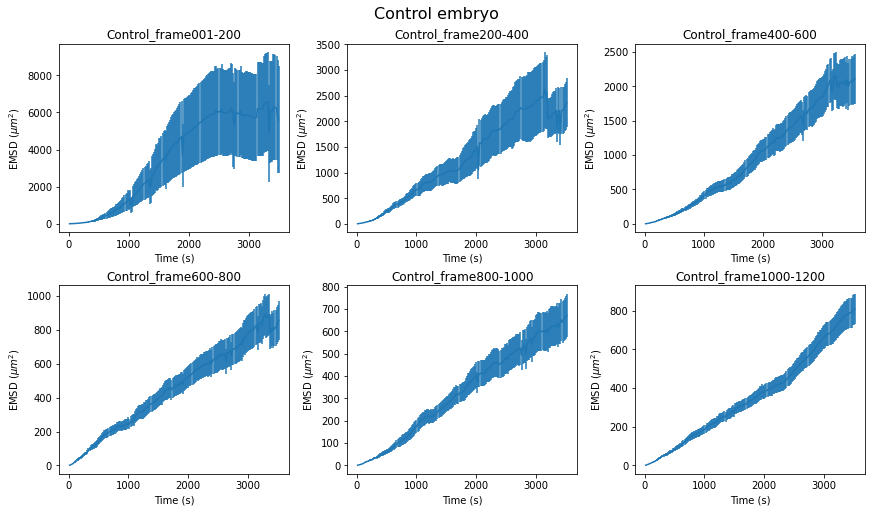

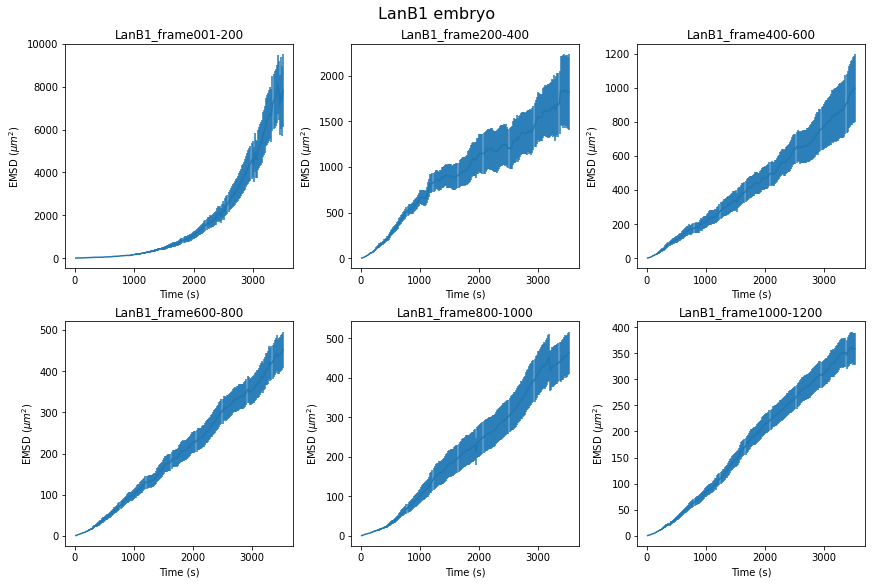

In [11]:
# with errorbars
#Control
fig, ax = plt.subplots(2, 3, figsize=(12, 7), constrained_layout=True)
fig.suptitle("Control embryo", fontsize=16)
for j, f in enumerate(filenames[0:3]):
    subplot_emsd_time(f, window, step_sizes, restriction, pos=[0,j], errorbar=True)
for j, f in enumerate(filenames[3:6]):
    subplot_emsd_time(f, window, step_sizes, restriction, pos=[1,j], errorbar=True)

#Mutant
fig, ax = plt.subplots(2, 3, figsize=(12, 8), constrained_layout=True)
fig.suptitle("LanB1 embryo", fontsize=16)
for j, f in enumerate(filenames[6:9]):
    subplot_emsd_time(f, window, step_sizes, restriction, pos=[0,j], errorbar=True)
for j, f in enumerate(filenames[9:12]):
    subplot_emsd_time(f, window, step_sizes, restriction, pos=[1,j], errorbar=True)

### Time-averaged mean squared displacement (TMSD) and its ensemble average (ETMSD)

Calculated as in: <br>
Arcizet D, Meier B, Sackmann E, Raedler J O and Heinrich D
2008 Phys. Rev. Lett. 101 248103
<br>
$\langle\Delta r^2(\tau)\rangle_t = \langle[x(t+\tau)-x(t)]^2 + [y(t+\tau)-y(t)]^2 + [z(t+\tau)-z(t)]^2\rangle_t$ <br>
$\tau$ is lag time (downsampling time intervals). <br>
The TMSD can be averaged over all the tracks to get the ETMSD.

In [103]:
def get_etmsd(filename, step_sizes, window, restriction):
    
    etmsd_values = np.empty(len(step_sizes))
    etmsd_err_values = np.empty(len(step_sizes))
    lag_times = np.empty(len(step_sizes))
    
    for i, s in enumerate(step_sizes):
        disp_time_dict = get_disp_time_dict_from_file(filename, window, s, max(step_sizes), restriction)
        step_length_dict = get_step_length_dict_from_file(filename, window, s, max(step_sizes), restriction)
        
        keys_list = list(disp_time_dict) # keys are 'TrackID[downsampling start index]'
        
#         tdiff_values = np.array([])
#         for ds_tid in keys_list:
#             times = np.array(disp_time_dict[ds_tid])
#             tdiff = times[1:]-times[0:-1]
#             tdiff_values = np.append(tdiff_values, tdiff)
#         tau = stats.mode(tdiff_values)[0][0]
        tau = s*17.6
        lag_times[i] = tau
        
        tmsd_values = np.array([])
        tmsd_errs = np.array([])
        for ds_tid in keys_list:
            step_lengths = np.array(step_length_dict[ds_tid])
            tmsd_values = np.append(tmsd_values, np.mean(np.power(step_lengths,2)))
            #tmsd_errs = np.append(tmsd_errs,np.std(np.power(step_lengths,2)))
            #plt.scatter([tau]*len(tmsd_values), tmsd_values)
        etmsd_values[i] = np.mean(tmsd_values)
        etmsd_err_values[i] = np.std(tmsd_values)/np.sqrt(len(tmsd_values))
        
    return lag_times, etmsd_values,etmsd_err_values

In [104]:
f = filenames[1]
window = 20
step_sizes = [1,2,3,4,5,6,7,8]
restriction = 10000

In [105]:
lag_times, etmsd_values,etmsd_errs = get_etmsd(f, step_sizes, window, restriction)

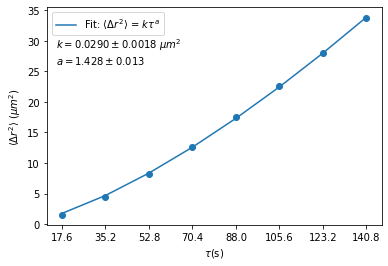

In [106]:
plt.scatter(lag_times, etmsd_values)
plt.xlabel(r'$\tau$(s)')
plt.ylabel(r'$\langle{\Delta r}^2\rangle$ ($\mu m^2$)')
plt.xticks(lag_times)
#plt.yticks(etmsd_values)
popt, pcov = curve_fit(power_law, lag_times, etmsd_values)
perr = np.sqrt(np.diag(pcov))
plt.plot(lag_times, power_law(lag_times, *popt), label=r'Fit: $\langle{\Delta r}^2\rangle$ = $k\tau^a$')
plt.annotate(r'$k={:.4f}\pm{:.4f}$ $\mu m^2$'.format(popt[0],perr[0])+'\n'+r'$a={:.3f}\pm{:.3f}$'.format(popt[1],perr[1]),
             (0.13,0.7), xycoords='figure fraction')
plt.legend()

In [172]:
def subplot_etmsd_time(filename, window, step_sizes, restriction, pos=None, subplot_title=None, label=None, color=None,
                       fmt='none', ms=None, annotate=True, errorbar=False, absolute_sigma=False):
    """
    """
    
    lag_times, etmsd_values, etmsd_errors = get_etmsd(filename, step_sizes, window, restriction)
    
    if pos!=None:
        i, j = pos
        ax[i,j].set_xlabel(r'$\tau$(s)')
        ax[i,j].set_ylabel(r'$\langle{\Delta r}^2\rangle$ ($\mu m^2$)')
        ax[i,j].set_xticks(lag_times)

        if subplot_title==None:
            subplot_title = filename
        ax[i,j].set_title(subplot_title)
    
    if errorbar:
        popt, pcov = curve_fit(power_law, lag_times, etmsd_values, sigma=etmsd_errors, absolute_sigma=absolute_sigma)
        perr = np.sqrt(np.diag(pcov))
        if pos!=None:
            ax[i,j].errorbar(lag_times, etmsd_values, yerr=etmsd_errors, fmt=fmt, ms=ms, label=label, color=color)
            #ax[i,j].errorbar(lag_times, etmsd_values, yerr=etmsd_errors, fmt='none', label=label, color=color)
            #ax[i,j].errorbar(lag_times, etmsd_values, yerr=etmsd_errors, fmt='x', label=label, color=color)
    else:
        popt, pcov = curve_fit(power_law, lag_times, etmsd_values)
        perr = np.sqrt(np.diag(pcov))
        if pos!=None:
            ax[i,j].scatter(lag_times, etmsd_values)
        
    if pos!=None:
        if label==None:
            label = r'Fit: $\langle{\Delta r}^2\rangle$ = $k\tau^a$'
        ax[i,j].plot(lag_times, power_law(lag_times, *popt), color=color, ls='-', alpha=0.5)#, label=label+' power law fit')

        if annotate:
            ax[i,j].annotate(r'$k={:.4f}\pm{:.4f}$ $\mu m^2$'.format(popt[0],perr[0])+'\n'
                             +r'$a={:.3f}\pm{:.3f}$'.format(popt[1],perr[1])+'\n'
                             +r'$H=a/2={:.3f}\pm{:.3f}$'.format(popt[1]/2,perr[1]/2),(0.1,0.65), xycoords='axes fraction')
        ax[i,j].legend()
    
    if pos==None:
        return popt, perr

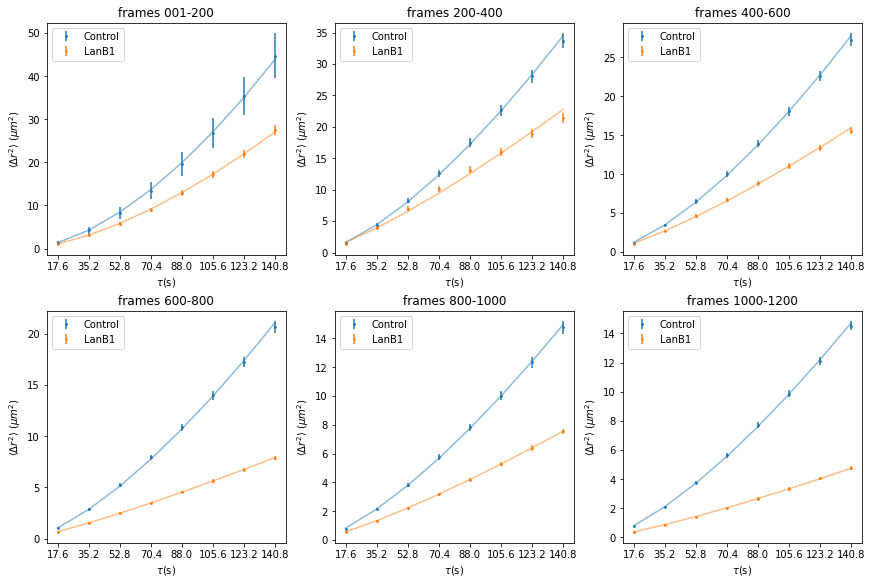

In [173]:
#combined plot
#Control and LanB1 combined
fig, ax = plt.subplots(2, 3, figsize=(12, 8), constrained_layout=True)
sub_titles = ['frames 001-200', 'frames 200-400', 'frames 400-600', 'frames 600-800', 'frames 800-1000', 'frames 1000-1200']
colors = ['C0', 'C1']
fmt = '.' #marker
ms = 3.5  #marker size
for j, f in enumerate(filenames[0:3]):
    subplot_etmsd_time(f, window, step_sizes, restriction, pos=[0,j], errorbar=True, absolute_sigma=True,
                       subplot_title=sub_titles[j], label='Control', color=colors[0], fmt=fmt, ms=ms, annotate=False)
for j, f in enumerate(filenames[3:6]):
    subplot_etmsd_time(f, window, step_sizes, restriction, pos=[1,j], errorbar=True, absolute_sigma=True,
                       subplot_title=sub_titles[3+j], label='Control', color=colors[0], fmt=fmt, ms=ms, annotate=False)
for j, f in enumerate(filenames[6:9]):
    subplot_etmsd_time(f, window, step_sizes, restriction, pos=[0,j], errorbar=True, absolute_sigma=True,
                       subplot_title=sub_titles[j], label='LanB1', color=colors[1], fmt=fmt, ms=ms, annotate=False)
for j, f in enumerate(filenames[9:12]):
    subplot_etmsd_time(f, window, step_sizes, restriction, pos=[1,j], errorbar=True, absolute_sigma=True,
                       subplot_title=sub_titles[3+j], label='LanB1', color=colors[1], fmt=fmt, ms=ms, annotate=False)
plt.savefig('etmsd_plots/'+'etmsd_plot_'+'combined_'+'w{}_s{}_r{}_'.format(window, max(step_sizes), restriction), dpi=300, facecolor='white')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

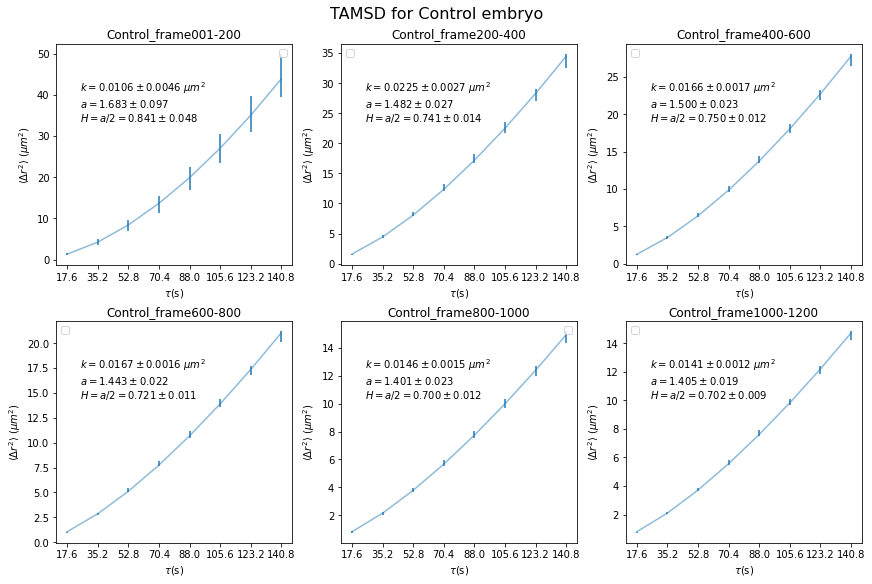

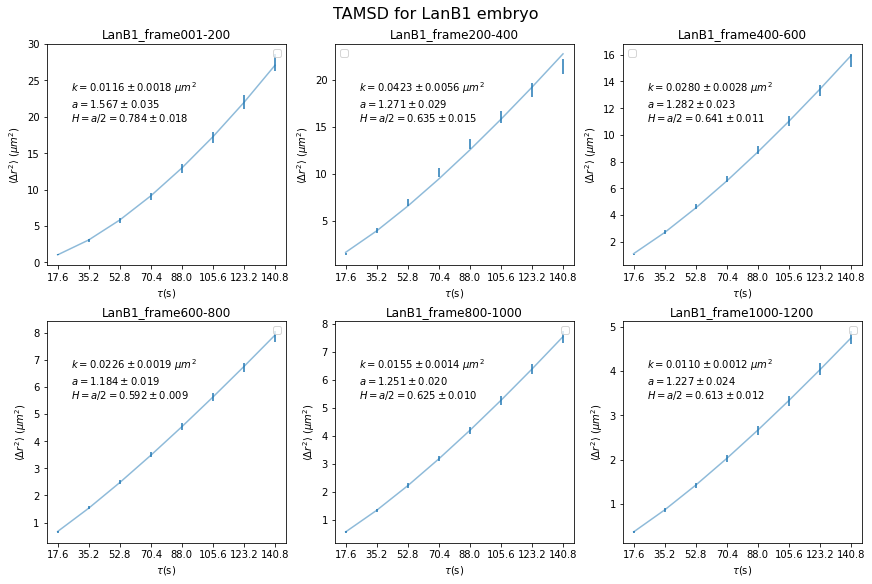

In [174]:
# with errorbars
#Control
fig, ax = plt.subplots(2, 3, figsize=(12, 8), constrained_layout=True)
fig.suptitle("TAMSD for Control embryo", fontsize=16)
for j, f in enumerate(filenames[0:3]):
    subplot_etmsd_time(f, window, step_sizes, restriction, pos=[0,j], errorbar=True, absolute_sigma=True)
for j, f in enumerate(filenames[3:6]):
    subplot_etmsd_time(f, window, step_sizes, restriction, pos=[1,j], errorbar=True, absolute_sigma=True)

#Mutant
fig, ax = plt.subplots(2, 3, figsize=(12, 8), constrained_layout=True)
fig.suptitle("TAMSD for LanB1 embryo", fontsize=16)
for j, f in enumerate(filenames[6:9]):
    subplot_etmsd_time(f, window, step_sizes, restriction, pos=[0,j], errorbar=True, absolute_sigma=True)
for j, f in enumerate(filenames[9:12]):
    subplot_etmsd_time(f, window, step_sizes, restriction, pos=[1,j], errorbar=True, absolute_sigma=True)

In [175]:
k_values = np.array([])
anom_exp_values = np.array([])
anom_exp_errors = np.array([])
for f in filenames[0:12]:
    popt, perr = subplot_etmsd_time(f, window, step_sizes, restriction, errorbar=True, absolute_sigma=True)
    k_values = np.append(k_values, popt[0])
    anom_exp_values = np.append(anom_exp_values, popt[1])
    anom_exp_errors = np.append(anom_exp_errors, perr[1])

In [177]:
ds_at_min = np.array([0, 6, 5, 5, 5, 4, 4, 6, 5, 3, 3, 2])  #just reading off values from <cos(theta)> vs R_ds plots, first 
                                                            #control file did not show a minimum so just put 0 for now
tau_at_min = ds_at_min*17.6
etmsd_at_min = power_law(tau_at_min, k_values, anom_exp_values)
length_scales = np.sqrt(etmsd_at_min)

In [180]:
import pandas as pd
d = {r'$\alpha$': anom_exp_values, r'$\sigma_\alpha$': anom_exp_errors, r'$R_{ds}$ at min': ds_at_min,
     r'length scale$({\mu}m)$': length_scales}
df = pd.DataFrame(data=d)
df.index = filenames[0:12]

In [181]:
df

,$\alpha$,$\sigma_\alpha$,$R_{ds}$ at min,length scale$({\mu}m)$
Control_frame001-200,1.682741,0.096787,0,0.000000
Control_frame200-400,1.482389,0.027341,6,4.744684
Control_frame400-600,1.499779,0.023377,5,3.703746
Control_frame600-800,1.442565,0.021901,5,3.269065
Control_frame800-1000,1.400531,0.023055,5,2.781868
Control_frame1000-1200,1.404745,0.018876,4,2.357702
LanB1_frame001-200,1.567084,0.035427,4,3.022103
LanB1_frame200-400,1.270965,0.029478,6,3.973610
LanB1_frame400-600,1.282169,0.022894,5,2.953144
LanB1_frame600-800,1.184168,0.018848,3,1.573451


# Scrap

Old version of get_emsd function which did not take into account that some tracks don't start from time 0:

In [ ]:
# def get_emsd(disp_dict, disp_time_dict):
    
#     max_length = max(len(disps) for disps in disp_dict.values())
    
#     emsd_means = np.empty(max_length)
#     #emsd_stds = np.empty(max_length)
#     emsd_error = np.empty(max_length)
#     times = np.empty(max_length)
    
#     for i in range(max_length):
#         temp_disp_dict = {key:disps for (key,disps) in disp_dict.items() if len(disps) > i}
#         temp_time_dict = {key:t for (key,t) in disp_time_dict.items() if len(t) > i}
#         # displ for all tracks at this time
#         squared_disps_at_time = [(disps[i])**2 for disps in temp_disp_dict.values()]
#         temp_mean = np.mean(squared_disps_at_time)
#         temp_std = np.std(squared_disps_at_time)
#         emsd_means[i] = temp_mean
#         #emsd_stds[i] = temp_std
#         emsd_error[i] = temp_std/np.sqrt(len(temp_disp_dict)-1)
        
#         temp_times = [t[i] for t in temp_time_dict.values()]
#         #times[i] = temp_times[0]  # ????????????????????
#         times[i] = np.mean(temp_times)   # ????????????????
#         print([t[i] for t in temp_time_dict.values()]) # ????????????????
        
#     return emsd_means[1:], emsd_error[1:], times[1:]

Old version of get_etmsd that used displacements relative to first point instead of step lengths.

In [ ]:
# def get_etmsd(filename, step_sizes, window, restriction):
    
#     etmsd_values = np.empty(len(step_sizes))
#     lag_times = np.empty(len(step_sizes))
    
#     for i, s in enumerate(step_sizes):
#         disp_dict = get_disp_dict_from_file(filename, window, s, max(step_sizes), restriction)
#         disp_time_dict = get_disp_time_dict_from_file(filename, window, s, max(step_sizes), restriction)
        
#         keys_list = list(disp_dict) # keys are 'TrackID[downsampling start index]'
        
#         tdiff_values = np.array([])
#         for ds_tid in keys_list:
#             times = np.array(disp_time_dict[ds_tid])
#             tdiff = times[1:]-times[0:-1]
#             tdiff_values = np.append(tdiff_values, tdiff)
#         tau = stats.mode(tdiff_values)[0][0]
#         lag_times[i] = tau
        
#         tmsd_values = np.array([])
#         for ds_tid in keys_list:
#             disps = np.array(disp_dict[ds_tid])
#             squared_disps = np.power(disps,2)
#             tmsd_values = np.append(tmsd_values, np.mean(squared_disps)) 
#             plt.scatter([tau]*len(tmsd_values), tmsd_values)
#         etmsd_values[i] = np.mean(tmsd_values)
        
#     return etmsd_values, lag_times
        